In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, Flatten, Reshape
from tensorflow.keras.models import Model
from random import shuffle
import datetime
import math
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
pd.set_option('display.max_rows', 100)
#Just to have each print in the same row
CSS = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
r'''   
data_w_operacion: (DataFrame) data with their corresponding operacion (Entrada/Salida).
    path: C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv

tandil_filtered_normalized: (DataFrame) weather information of Tandil from 01/01/2019 to 31/12/2019

data_w_weather: (DataFrame) data_w_operacion merged with tandil_filtered_normalized
'''

data_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv'
weather_path = r'C:\Users\ing_l\Tesis grado\Data\Weather data\tandil_filtered_normalized.csv'
data_w_weather_path = r'C:\Users\ing_l\Tesis grado\Data\data_w_weather.csv'
max_ocup_path = r'C:\Users\ing_l\Tesis grado\Data\max_ocup.txt'

In [4]:
#Time intervals
period = -1 #3 - 3

#How much data we will use to feed the lstm
train_size = 10 #7 - 4

#How much different values we want as input of the LSTM (i.e. tolerance 3/train_size 5: 0,1,2,2,1)
#Must be less or equals than train_size
tolerance = 0 #5 - 3

#which columns we'll use as input of the LSTM, features are how much colums we have
#data_columns = ['tiempo', 'ocupacion','operacion']
data_columns = ['ocupacion','operacion']
features = len(data_columns)

#if we want the target to be different to the last value of the data
control_target = False

dateweek_columns = ['id_cuadra','dia de semana', 'tiempo', 'ocupacion','operacion','estacion', 'fecha', 'FeelsLikeC', 'precipMM', 'windspeedKmph', 'dif_tiempo']

In [5]:
'''data = pd.read_csv(data_path, parse_dates=['fecha_tiempo'])
weather = pd.read_csv(weather_path, parse_dates=[['date','time']])'''

"data = pd.read_csv(data_path, parse_dates=['fecha_tiempo'])\nweather = pd.read_csv(weather_path, parse_dates=[['date','time']])"

In [6]:
'''weather['time'] = weather['date_time'].apply(lambda x: x.hour)
weather['date'] = weather['date_time'].apply(lambda x: x.date())'''

"weather['time'] = weather['date_time'].apply(lambda x: x.hour)\nweather['date'] = weather['date_time'].apply(lambda x: x.date())"

In [7]:
'''weather'''

'weather'

In [8]:
'''data['dia de semana'] = data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).weekday())
data['tiempo'] = data['tiempo'].apply(lambda x: pd.Timestamp(x).time())
data['fecha'] = data['fecha'].apply(lambda x: pd.Timestamp(x).date())'''

"data['dia de semana'] = data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).weekday())\ndata['tiempo'] = data['tiempo'].apply(lambda x: pd.Timestamp(x).time())\ndata['fecha'] = data['fecha'].apply(lambda x: pd.Timestamp(x).date())"

In [9]:
'''#Me quedo con los que estan entre las 8 y las 21hs
data = data.loc[(data.tiempo > datetime.time(8)) & (data.tiempo < datetime.time(21))].reset_index(drop=True)'''

'#Me quedo con los que estan entre las 8 y las 21hs\ndata = data.loc[(data.tiempo > datetime.time(8)) & (data.tiempo < datetime.time(21))].reset_index(drop=True)'

In [10]:
'''data'''

'data'

In [11]:
data_week = pd.read_csv(data_w_weather_path, parse_dates=['fecha']).drop('Unnamed: 0', axis=1)

In [12]:
max_street_num = data_week.loc[:,'id_cuadra'].max()
print('Max street id: ', max_street_num)

Max street id:  99


In [13]:
'''
La idea de la red seria que de input tenga fecha_tiempo (o por ahi mejor, solo dia de la semana), 
la ocupacion de esa fecha_tiempo, el clima.
Como output deberia tener la ocupacion de ese momento.

Aparte a todo eso se deberia ver la ocupacion actual y la ocupacion maxima para saber si hay lugar libre.
'''

def to_seconds(time):
    '''transform datetime.time to seconds'''
    return time.hour * 60 * 60 + time.minute * 60 + time.second

def normalize_time(time):
    '''normalize time (in seconds) to values bertween 0 and 1'''
    max_time = 23 * 60 * 60 + 59 * 60 + 59
    return time / max_time

def modify_operation(operation):
    '''if operacion == Entrada sets value to 1, == NaN sets to 0 and == Salida sets to -1'''
    if operation == 'Entrada':
        return 1
    if operation == 'Salida':
        return -1
    return 0

def normalize_ocupation(row):
    '''normalize ocupation to values between 0 and 1, using the lugares_cuadra value'''
    global max_ocup
    return (row['ocupacion'] / max_ocup)

def get_season(fecha):
    fecha = pd.to_datetime(fecha, dayfirst=True)
    d = fecha.day
    m = fecha.month * 100
    md = m + d
    if ((md >= 921) and (md <= 1220)):
        season = 0  # spring
    elif ((md >= 1221) and (md <= 320)):
        season = 1  # summer
    elif ((md >= 321) and (md <= 620)):
        season = 2  # fall
    elif ((md >= 621) and (md <= 920)):
        season = 3  # winter
    return season

#Because now im reading it from a file
if False:
    data_week = data.loc[:, ['id_cuadra','dia de semana', 'tiempo', 'ocupacion','operacion','fecha', 'FeelsLikeC', 'precipMM', 'windspeedKmph']]
    data_week['tiempo'] = data_week['tiempo'].apply(to_seconds)
    data_week['operacion'] = data_week['operacion'].apply(modify_operation)
    data_week['estacion'] = data_week['fecha'].apply(get_season)

    max_ocup = data['lugares_cuadra'].max()
    data_week['ocupacion'] = data_week.apply(normalize_ocupation, axis=1)
    data_week = data_week.loc[:, dateweek_columns]

In [14]:
max_ocup = int(float(open(max_ocup_path, 'r').read()))
print('max_ocup: ', max_ocup)

max_ocup:  51


In [15]:
data_week

,id_cuadra,dia de semana,tiempo,ocupacion,operacion,estacion,fecha,FeelsLikeC,precipMM,windspeedKmph
0,2,2,62131,0.117647,0,0,2019-11-09,0.638298,0.000000,0.317073
1,2,2,62425,0.137255,1,0,2019-11-09,0.638298,0.000000,0.317073
2,2,2,63294,0.117647,-1,0,2019-11-09,0.638298,0.000000,0.317073
3,2,2,63609,0.098039,-1,0,2019-11-09,0.638298,0.000000,0.317073
4,2,2,63905,0.117647,1,0,2019-11-09,0.638298,0.000000,0.317073
...,...,...,...,...,...,...,...,...,...,...
281026,99,2,44061,0.078431,-1,0,2019-11-12,0.531915,0.056034,0.463415
281027,99,2,44421,0.058824,-1,0,2019-11-12,0.531915,0.056034,0.463415
281028,99,2,45006,0.078431,1,0,2019-11-12,0.531915,0.056034,0.463415
281029,99,2,45622,0.058824,-1,0,2019-11-12,0.531915,0.056034,0.463415


In [16]:
#To obtain the start and finish of each day, usefull to normalize data times

indexes = [0]

total_len = 1

x = data_week.reset_index()
exit = False
while (total_len > 0) and not exit:
    #print(total_len)
    total_len = len(x.loc[x.loc[indexes[-1]:, 'dia de semana'].drop_duplicates().index, 'index'])
    try:
        indexes.append(x.loc[x.loc[indexes[-1]:, 'dia de semana'].drop_duplicates().index, 'index'].iloc[1])
    except:
        exit = True
        print('Work complete.')

Work complete.


In [17]:
idx_1 = indexes[0:len(indexes)-1]
idx_2 = indexes[1:len(indexes)]

data_week_dif_tiempo = pd.DataFrame(columns=['id_cuadra','dia de semana', 'tiempo', 'ocupacion','operacion','estacion', 'fecha', 'FeelsLikeC', 'precipMM', 'windspeedKmph','dif_tiempo'])

def calculate_time(data):

    for i, j in zip( range(0,len(data)-1), range(1, len(data))):
        #data.iloc[j].dif_tiempo = 
        data.loc[data.index == j, 'dif_tiempo'] = data.iloc[j].tiempo - data.iloc[i].tiempo
    #print(data)
    return data
    
data_week['dif_tiempo'] = 0
for i in range(len(indexes)-1):
    data_week_dif_tiempo = data_week_dif_tiempo.append(calculate_time(data_week[indexes[i]:indexes[i+1]].reset_index(drop=True)))
data_week = data_week_dif_tiempo

In [18]:
data_week_dif_tiempo[0:100]

,id_cuadra,dia de semana,tiempo,ocupacion,operacion,estacion,fecha,FeelsLikeC,precipMM,windspeedKmph,dif_tiempo
0,2,2,62131,0.117647,0,0,2019-11-09,0.638298,0.0,0.317073,0
1,2,2,62425,0.137255,1,0,2019-11-09,0.638298,0.0,0.317073,294
2,2,2,63294,0.117647,-1,0,2019-11-09,0.638298,0.0,0.317073,869
3,2,2,63609,0.098039,-1,0,2019-11-09,0.638298,0.0,0.317073,315
4,2,2,63905,0.117647,1,0,2019-11-09,0.638298,0.0,0.317073,296
5,2,2,64483,0.137255,1,0,2019-11-09,0.638298,0.0,0.317073,578
6,2,2,64829,0.156863,1,0,2019-11-09,0.531915,0.0,0.560976,346
7,2,2,64829,0.176471,1,0,2019-11-09,0.531915,0.0,0.560976,0
8,2,2,65058,0.196078,1,0,2019-11-09,0.531915,0.0,0.560976,229
9,2,2,65058,0.215686,1,0,2019-11-09,0.531915,0.0,0.560976,0


In [19]:
#Suponiendo que me llega solo un df conteniendo un solo dia (y esto lo hago para todos los dias y para cada calle)
def normalize_data_period(data, period=5):
    '''
        normalize data in periods for a day
    '''
    seconds = period * 60
    out = pd.DataFrame(columns=dateweek_columns)
    out = out.append(data.iloc[0])
    dist_to_period = out.iloc[-1].tiempo % seconds
    if (dist_to_period) != 0:
        out.iloc[-1].tiempo = out.iloc[-1].tiempo - dist_to_period
        
    for i in range(math.ceil((data.iloc[-1].tiempo - data.iloc[0].tiempo) / seconds)):
        next_period = data.loc[data.tiempo < (out.iloc[-1].tiempo+seconds)]
        if (len(next_period) == 0):
            out = out.append(out.iloc[-1])
            out.iloc[-1].tiempo = out.iloc[-1] + seconds
        else:
            out = out.append(next_period.iloc[-1])
            out.iloc[-1].tiempo = out.iloc[-2].tiempo + seconds
        if ( out.iloc[-2].ocupacion == out.iloc[-1].ocupacion):
            out.iloc[-1].operacion = 0
    return out.reset_index(drop=True)

In [20]:
#Normalizes all the data times. Divide the data into x minutes intervals
if period > 0: #if period < 0 we will uses the original time of the dataset
    normalized_data = pd.DataFrame(columns=dateweek_columns)
    for i in range(len(indexes)-1):
        clear_output()
        print('Iteracion {} de {}'.format(i, len(indexes)-2))
        normalized_data = normalized_data.append(normalize_data_period(data_week[indexes[i]:indexes[i+1]].copy(), period=period) )
    normalized_data = normalized_data.append(normalize_data_period(data_week[indexes[-1]:len(data_week)].copy(), period=period) )
else:
    normalized_data = data_week.copy()

In [21]:
normalized_data

,id_cuadra,dia de semana,tiempo,ocupacion,operacion,estacion,fecha,FeelsLikeC,precipMM,windspeedKmph,dif_tiempo
0,2,2,62131,0.117647,0,0,2019-11-09,0.638298,0.00000,0.317073,0
1,2,2,62425,0.137255,1,0,2019-11-09,0.638298,0.00000,0.317073,294
2,2,2,63294,0.117647,-1,0,2019-11-09,0.638298,0.00000,0.317073,869
3,2,2,63609,0.098039,-1,0,2019-11-09,0.638298,0.00000,0.317073,315
4,2,2,63905,0.117647,1,0,2019-11-09,0.638298,0.00000,0.317073,296
...,...,...,...,...,...,...,...,...,...,...,...
37,99,1,67832,0.058824,1,0,2019-10-12,0.574468,0.00431,0.146341,435
38,99,1,67955,0.078431,1,0,2019-10-12,0.574468,0.00431,0.146341,123
39,99,1,68429,0.058824,-1,0,2019-10-12,0.574468,0.00431,0.146341,474
40,99,1,72972,0.039216,-1,0,2019-10-12,0.574468,0.00431,0.146341,4543


In [22]:
#Normalize the tiempo column to values between 0 and 1
normalized_data['tiempo'] = normalized_data['tiempo'].apply(normalize_time)

In [23]:
def separate_data_per_street(data, street):
    '''
    Divide the df that contains all the streets into a list.
    Which position contains a data of a designed street
    '''
    return data.loc[data.id_cuadra == street]

data_separate = []
for i in (normalized_data['id_cuadra'].drop_duplicates()):
    data_separate.append(separate_data_per_street(normalized_data, i))

In [24]:
data_separate[0][100:200]

,id_cuadra,dia de semana,tiempo,ocupacion,operacion,estacion,fecha,FeelsLikeC,precipMM,windspeedKmph,dif_tiempo
67,2,3,0.600053,0.176471,-1,0,2019-12-09,0.744681,0.0,0.341463,0
68,2,3,0.615273,0.156863,-1,0,2019-12-09,0.744681,0.0,0.341463,1315
69,2,3,0.615273,0.156863,-1,0,2019-12-09,0.744681,0.0,0.341463,0
70,2,3,0.618317,0.137255,-1,0,2019-12-09,0.744681,0.0,0.341463,263
71,2,3,0.618317,0.137255,-1,0,2019-12-09,0.744681,0.0,0.341463,0
72,2,3,0.625331,0.117647,-1,0,2019-12-09,0.851064,0.0,0.341463,606
73,2,3,0.625331,0.117647,-1,0,2019-12-09,0.851064,0.0,0.341463,0
74,2,3,0.625713,0.098039,-1,0,2019-12-09,0.851064,0.0,0.341463,33
75,2,3,0.625713,0.098039,-1,0,2019-12-09,0.851064,0.0,0.341463,0
76,2,3,0.646107,0.117647,1,0,2019-12-09,0.851064,0.0,0.341463,1762


In [25]:
#este es el nuevo
def prepare_train_data(data, street, train_size=3, tolerance=0, data_columns=['tiempo','ocupacion','operacion'], control_target=False):
    '''
    Puts train_size values in a row with 
    '''   
    train_data = []
    train_street = []
    train_weekday = []
    train_season = []
    train_weather = []
    targets = []
    time_targets = []
    dif_time_targets = []

    #We dont have any value in sunday
    for weekday in range(0, 6):
        data_weekday = data.loc[data['dia de semana'] == weekday]
        
        for s in range(0, 4):
            data_season = data_weekday.loc[data_weekday['estacion'] == s]

            for day in data_season['fecha'].drop_duplicates():
                d = data_season.loc[data_season['fecha'] == day]
                d.drop_duplicates(subset='tiempo', keep='first', inplace=True)
                
                for i in range(len(d)-train_size-1):
                    data_to_add = d[i:i+train_size].loc[:, data_columns]

                    if len(data_to_add['ocupacion'].drop_duplicates()) >= tolerance:

                        if control_target:
                            if (data_to_add['ocupacion'].iloc[train_size-1]) != (d.iloc[i+train_size]['ocupacion']):
                                train_data.append(np.array(data_to_add.values)) 
                                train_street.append(street)
                                train_weekday.append(weekday)
                                train_season.append(s)
                                train_weather.append(d.iloc[i+train_size-1][['FeelsLikeC', 'precipMM', 'windspeedKmph']])
                                targets.append(d.iloc[i+train_size]['ocupacion'])               
                                time_targets.append(d.iloc[i+train_size]['tiempo'])               
                                dif_time_targets.append(d.iloc[i+train_size]['dif_tiempo'])               
                        else:
                            train_data.append(np.array(data_to_add.values)) 
                            train_street.append(street)
                            train_weekday.append(weekday)
                            train_season.append(s)
                            train_weather.append(d.iloc[i+train_size-1][['FeelsLikeC', 'precipMM', 'windspeedKmph']])
                            targets.append(d.iloc[i+train_size]['ocupacion'])
                            time_targets.append(d.iloc[i+train_size]['tiempo'])
                            dif_time_targets.append(d.iloc[i+train_size]['dif_tiempo'])

        #TODO: delete train_time
        #train_time.append(np.array(data_weekday[train_size:].loc[:,'tiempo'].values))

    #return np.array(train_data), np.array(train_street), np.array(train_weekday), np.array(train_time), np.array(targets)
    return np.array(train_data), np.array(train_street), np.array(train_weekday), np.array(train_season), np.array(train_weather), np.array(targets), np.array(time_targets), np.array(dif_time_targets)
    
        
train_data = []
train_street = []
train_weekday = []
train_season = []
train_weather = []
#train_time = []
targets = []
time_targets = []
dif_time_targets = []

for street in range(len(normalized_data['id_cuadra'].drop_duplicates())):
    clear_output()
    print('Calle num: ', street)
    #p_train_data, p_train_street, p_train_weekday, p_train_time, p_targets = prepare_train_data(data_separate[street], street, train_size=train_size, tolerance=tolerance, operation=operation, control_target=control_target)
    p_train_data, p_train_street, p_train_weekday, p_train_season, p_train_weather, p_targets, p_time_targets, p_dif_time_targets = prepare_train_data(data_separate[street], street, train_size=train_size, tolerance=tolerance, data_columns=data_columns, control_target=control_target)
    train_data.append(p_train_data)
    train_street.append(p_train_street)
    train_weekday.append(p_train_weekday)
    train_season.append(p_train_season)
    train_weather.append(p_train_weather)
    #train_time.append(p_train_time)
    targets.append(p_targets)
    time_targets.append(p_time_targets)
    dif_time_targets.append(p_dif_time_targets)

Calle num:  96


In [26]:
'''#este ANDA
def prepare_train_data(data, street, train_size=3, tolerance=0, data_columns=['tiempo','ocupacion','operacion'], control_target=False):
    
    #Puts train_size values in a row with 
       
    train_data = []
    train_street = []
    train_weekday = []
    train_season = []
    targets = []

    #We dont have any value in sunday
    for weekday in range(0, 6):
        data_weekday = data.loc[data['dia de semana'] == weekday]
        
        for s in range(0, 4):
            data_season = data_weekday.loc[data_weekday['estacion'] == s]

            for i in range(len(data_season)-train_size-1):
                data_to_add = data_season[i:i+train_size].loc[:, data_columns]
                
                if len(data_to_add['ocupacion'].drop_duplicates()) >= tolerance:
                    
                    if control_target:
                        if (data_to_add['ocupacion'].iloc[train_size-1]) != (data_season.iloc[i+train_size+1]['ocupacion']):
                            train_data.append(np.array(data_to_add.values)) 
                            train_street.append(street)
                            train_weekday.append(weekday)
                            train_season.append(s)
                            targets.append(data_season.iloc[i+train_size+1]['ocupacion'])               
                    else:
                        train_data.append(np.array(data_to_add.values)) 
                        train_street.append(street)
                        train_weekday.append(weekday)
                        train_season.append(s)
                        targets.append(data_season.iloc[i+train_size+1]['ocupacion'])
                        
        #TODO: delete train_time
        #train_time.append(np.array(data_weekday[train_size:].loc[:,'tiempo'].values))

    #return np.array(train_data), np.array(train_street), np.array(train_weekday), np.array(train_time), np.array(targets)
    return np.array(train_data), np.array(train_street), np.array(train_weekday), np.array(train_season), np.array(targets)
    
        
train_data = []
train_street = []
train_weekday = []
train_season = []
#train_time = []
targets = []

for street in range(len(normalized_data['id_cuadra'].drop_duplicates())):
    clear_output()
    print('Calle num: ', street)
    #p_train_data, p_train_street, p_train_weekday, p_train_time, p_targets = prepare_train_data(data_separate[street], street, train_size=train_size, tolerance=tolerance, operation=operation, control_target=control_target)
    p_train_data, p_train_street, p_train_weekday, p_train_season, p_targets = prepare_train_data(data_separate[street], street, train_size=train_size, tolerance=tolerance, data_columns=data_columns, control_target=control_target)
    train_data.append(p_train_data)
    train_street.append(p_train_street)
    train_weekday.append(p_train_weekday)
    train_season.append(p_train_season)
    #train_time.append(p_train_time)
    targets.append(p_targets)'''

"#este ANDA\ndef prepare_train_data(data, street, train_size=3, tolerance=0, data_columns=['tiempo','ocupacion','operacion'], control_target=False):\n    \n    #Puts train_size values in a row with \n       \n    train_data = []\n    train_street = []\n    train_weekday = []\n    train_season = []\n    targets = []\n\n    #We dont have any value in sunday\n    for weekday in range(0, 6):\n        data_weekday = data.loc[data['dia de semana'] == weekday]\n        \n        for s in range(0, 4):\n            data_season = data_weekday.loc[data_weekday['estacion'] == s]\n\n            for i in range(len(data_season)-train_size-1):\n                data_to_add = data_season[i:i+train_size].loc[:, data_columns]\n                \n                if len(data_to_add['ocupacion'].drop_duplicates()) >= tolerance:\n                    \n                    if control_target:\n                        if (data_to_add['ocupacion'].iloc[train_size-1]) != (data_season.iloc[i+train_size+1]['ocupacion'

In [27]:
'''train_street'''

'train_street'

In [28]:
'''train_data'''

'train_data'

In [29]:
'''targets.shape'''

'targets.shape'

In [30]:
#t_train_weekday.shape

In [31]:
t_train_street = train_street[0]
t_train_weekday = train_weekday[0]
t_train_data = train_data[0]
t_train_season = train_season[0]
t_train_weather = train_weather[0]
t_targets = targets[0]
t_time_targets = time_targets[0]
t_dif_time_targets = dif_time_targets[0]

In [32]:
'''t_train_street = train_street
t_train_weekday = train_weekday
t_train_data = train_data
t_train_season = train_season
t_targets = targets'''

't_train_street = train_street\nt_train_weekday = train_weekday\nt_train_data = train_data\nt_train_season = train_season\nt_targets = targets'

In [33]:
for i in range(len(train_street) - 1):
    t_train_street = np.concatenate([t_train_street, train_street[i+1]])
    t_train_weekday = np.concatenate([t_train_weekday, train_weekday[i+1]])
    t_train_season = np.concatenate([t_train_season, train_season[i+1]])
    t_targets = np.concatenate([t_targets, targets[i+1]])
    t_time_targets = np.concatenate([t_time_targets, time_targets[i+1]])
    t_dif_time_targets = np.concatenate([t_dif_time_targets, dif_time_targets[i+1]])

for i in range(len(train_weather) - 1):
    try:
        t_train_weather = np.concatenate([t_train_weather, train_weather[i+1]])
    except:
        print('Train weather have empty values.')

empty_streets = []
for i in range(len(train_data) - 1):
    clear_output()
    print('Iteration: {} of {}'.format(i+1, len(train_data) - 1))
    if len(train_data[i+1]) > 0:
        t_train_data = np.concatenate([t_train_data, train_data[i+1]])
    else:
        empty_streets.append(i+1)
print(empty_streets)

Iteration: 96 of 96
[89]


In [34]:
to_shuffle = list(zip(t_train_street, t_train_weekday, t_train_data, t_train_season, t_train_weather, t_targets, t_time_targets, t_dif_time_targets))
shuffle(to_shuffle)
s_train_street, s_train_weekday, s_train_data, s_train_season, s_train_weather, s_targets, s_time_targets, s_dif_time_targets = zip(*to_shuffle)

s_targets = np.array(s_targets)

In [35]:
'''x = tf.random.shuffle(t_train_street, seed=5)
y = tf.random.shuffle(t_train_weekday, seed=5)
z = tf.random.shuffle(t_targets, seed=5)
t = tf.random.shuffle(t_train_data, seed=5)'''

'x = tf.random.shuffle(t_train_street, seed=5)\ny = tf.random.shuffle(t_train_weekday, seed=5)\nz = tf.random.shuffle(t_targets, seed=5)\nt = tf.random.shuffle(t_train_data, seed=5)'

In [36]:
'''z'''

'z'

In [37]:
(t_train_data.shape)

(155121, 10, 2)

In [38]:
t_train_street = tf.convert_to_tensor(s_train_street, np.float64)
t_train_weekday = tf.convert_to_tensor(s_train_weekday, np.float64)
t_train_data = tf.convert_to_tensor(s_train_data, np.float64)
t_train_season = tf.convert_to_tensor(s_train_season, np.float64)
t_train_weather = tf.convert_to_tensor(s_train_weather, np.float64)
t_targets = tf.convert_to_tensor(s_targets, np.float64)
t_time_targets = tf.convert_to_tensor(s_time_targets, np.float64)
t_dif_time_targets = tf.convert_to_tensor(s_dif_time_targets, np.float64)

In [39]:
'''#Aplano todo y lo dejo para que entre a la red (elimino la division entre calles)
train_street = [y for x in train_street for y in x]
train_weekday = [y for x in train_weekday for y in x]
train_data = [y for x in train_data for y in x]
train_time = [y for x in train_time for y in x]
train_time = [y for x in train_time for y in x]
targets = [y for x in targets for y in x]
targets = [y for x in targets for y in x]
'''

#VER COMO HACER QUE ESTO FUNCIONE
'''
to_shuffle = list(zip(train_street, train_weekday, train_data, train_time, targets))
shuffle(to_shuffle)
s_train_street, s_train_weekday, s_train_data, s_train_time, s_targets = zip(*to_shuffle)

s_targets = np.array(s_targets)'''

'\nto_shuffle = list(zip(train_street, train_weekday, train_data, train_time, targets))\nshuffle(to_shuffle)\ns_train_street, s_train_weekday, s_train_data, s_train_time, s_targets = zip(*to_shuffle)\n\ns_targets = np.array(s_targets)'

In [40]:
'''t_train_data'''

't_train_data'

In [41]:
'''(t_targets)'''

'(t_targets)'

In [42]:
'''(s_train_weekday[0])'''

'(s_train_weekday[0])'

In [43]:
'''(s_train_data)'''

'(s_train_data)'

In [44]:
'''(s_train_time[0])'''

'(s_train_time[0])'

In [45]:
'''(s_targets[0])'''

'(s_targets[0])'

In [46]:
def denormalize_time(time):
    max_time = 23 * 60 * 60 + 59 * 60 + 59
    return pd.Timestamp(time * max_time, unit='s').time()

def denormalize_ocupation(ocupation):
    global max_ocup
    return ocupation * max_ocup

def clean_predictions(ocupation):
    if ocupation <= 0:
        return 0
    return round(ocupation)

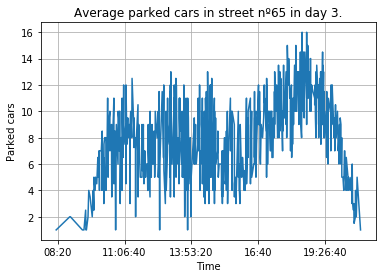

In [47]:
street = 65
weekday = 3


plot_data = normalized_data.loc[(normalized_data.id_cuadra == street) & (normalized_data['dia de semana'] == weekday), ['tiempo', 'ocupacion']]
plot_data = plot_data.groupby(by='tiempo').mean().reset_index()

plot_data['tiempo'] = plot_data['tiempo'].apply(denormalize_time)
plot_data['ocupacion'] = plot_data['ocupacion'].apply(denormalize_ocupation)

#Set the label titles
plt.xlabel('Time')
plt.ylabel('Parked cars')
plt.title('Average parked cars in street nº{} in day {}.'.format(street, weekday))

#Set the plot data for each graph (ax1,ax2,ax3)
plt.plot(plot_data['tiempo'], plot_data['ocupacion'])

plt.rcParams['figure.figsize'] = (15,8)
plt.grid()
#plt.xticks(normalized_data['fecha_hora'], time)
plt.show()

In [48]:
plot_data

,tiempo,ocupacion
0,08:16:16,1.0
1,08:50:14,2.0
2,08:51:43,2.0
3,09:21:32,1.0
4,09:25:33,1.0
...,...,...
598,20:42:49,2.0
599,20:44:02,2.0
600,20:44:30,2.5
601,20:46:04,5.0


In [49]:
#Para la calle
input_street = Input(shape=(1), name='input_street')
#emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=32)(input_street)
emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=16)(input_street)
flat_street = Flatten()(input_street)
#d_street = Dense(16, activation='relu')(flat_street)

#Para el dia de la semana
input_weekday = Input(shape=(1), name='input_weekday')
#emb_weekday = Embedding(input_length=1, input_dim=7, output_dim=16)(input_weekday)
emb_weekday = Embedding(input_length=1, input_dim=6, output_dim=8)(input_weekday)
flat_weekday = Flatten()(emb_weekday)
#d_weekday = Dense(8, activation='relu')(flat_weekday)

#Para el tiempo y la ocupacion y la operacion
input_data = Input(shape=(train_size, features), name='input_data')
#lstm = LSTM(16, return_sequences=False, recurrent_dropout=0.25)(input_data)
#lstm_layer = LSTM(8, return_sequences=True, recurrent_dropout=0.25)(input_data)
lstm = LSTM(8, return_sequences=False, recurrent_dropout=0.25)(input_data)

#Para la estacion del año
input_season = Input(shape=(1), name='input_season')
emb_season = Embedding(input_length=1, input_dim=4, output_dim=4)(input_season)
flat_season = Flatten()(emb_season)
#d_season = Dense(8, activation='relu')(flat_season)

#Para el clima
input_weather = Input(shape=(3), name='input_weather')


#Para el tiempo a predecir 
#No agrega valor, hace mas chota a la red. En vez de esto voy a arreglar el tiempo en los datos
#y hacer que sea cada cierta cantidad de minutos siempre.
#input_time = Input(shape=(1), name='input_time')

concat = Concatenate(axis=-1)
input_merge = concat([flat_weekday, flat_street])
input_merge = concat([input_merge, lstm])
input_merge = concat([input_merge, flat_season])
input_merge = concat([input_merge, input_weather])
#input_merge = concat([input_merge, input_time])

d = Dense(32, activation='relu')(input_merge)
d = Dropout(0.25)(d)
d = Dense(64, activation='relu')(d)
d = Dropout(0.5)(d)
d = Dense(64, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
#d = Dropout(0.5)(d)
#d = Dense(32, activation='relu')(d)
#d = Dropout(0.25)(d)
out = Dense(1, activation='linear')(d)

model = Model(inputs=[input_weekday, input_street, input_season, input_data, input_weather], outputs=out)
model.summary()
model.compile(loss='MSE', optimizer='adam', metrics=['MAE'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_weekday (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 8)         48          input_weekday[0][0]              
__________________________________________________________________________________________________
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 8)            0           embedding_1[0][0]                
______________________________________________________________________________________________

In [50]:
#h = model.fit([s_train_weekday, s_train_street, s_train_data], s_targets, epochs=5, batch_size=64, validation_split=0.1)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00000001)

#h = model.fit([t_train_weekday, t_train_street, t_train_data], t_targets, epochs=20, batch_size=32, validation_split=0.2, callbacks=[red_lr])
#h = model.fit([t_train_weekday, t_train_street, t_train_season, t_train_data], den_targets, epochs=20, batch_size=512, validation_split=0.2, callbacks=[red_lr])
h = model.fit([t_train_weekday, t_train_street, t_train_season, t_train_data, t_train_weather], t_targets, epochs=3, batch_size=64, validation_split=0.1, callbacks=[red_lr])

Train on 139608 samples, validate on 15513 samples
Epoch 1/3
139608/139608 [==============================] - 14s 99us/sample - loss: 0.3372 - MAE: 0.2030 - val_loss: 0.0065 - val_MAE: 0.0636
Epoch 2/3
139608/139608 [==============================] - 11s 76us/sample - loss: 0.0072 - MAE: 0.0642 - val_loss: 0.0064 - val_MAE: 0.0635
Epoch 3/3
139608/139608 [==============================] - 11s 76us/sample - loss: 0.0051 - MAE: 0.0542 - val_loss: 0.0035 - val_MAE: 0.0445


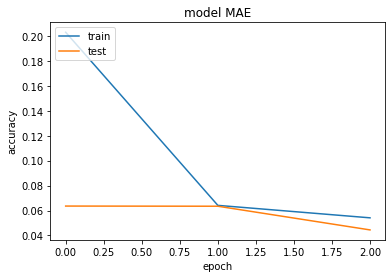

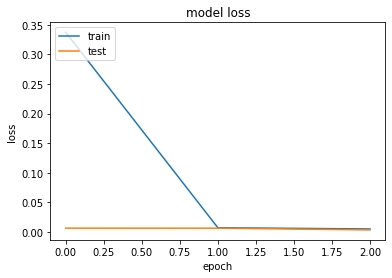

In [51]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['MAE'])
plt.plot(h.history['val_MAE'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
pd.DataFrame(h.history['loss']).apply(denormalize_ocupation)

,0
0,17.197121
1,0.364806
2,0.260414


In [53]:
index = 2

true_data = data_week[indexes[index]:indexes[index+1]].copy().reset_index(drop=True)
true_data['tiempo'].apply(normalize_time).apply(denormalize_time).drop_duplicates()

0      08:48:04
1      08:51:43
2      09:25:06
3      09:39:36
6      09:51:59
7      10:00:12
8      10:10:36
9      10:14:55
10     10:25:39
11     10:31:59
13     10:50:40
15     11:00:29
17     11:04:56
18     11:14:20
19     11:23:28
20     11:36:11
22     11:45:29
24     11:53:09
26     11:59:51
27     12:24:43
30     12:30:33
31     12:40:30
33     12:43:11
34     12:46:29
35     12:55:45
36     13:00:14
37     13:09:18
39     13:15:36
41     13:19:25
42     13:31:19
43     13:41:04
48     13:50:39
52     13:55:38
56     14:00:12
60     14:04:03
61     14:20:49
63     14:30:23
64     14:40:29
66     14:50:41
67     14:54:24
68     15:00:48
69     15:04:24
72     15:15:06
74     15:30:33
75     15:42:34
76     16:00:15
78     16:02:02
79     16:24:39
80     16:29:05
81     16:44:16
82     16:48:56
83     16:53:46
84     17:03:45
85     17:20:07
86     17:30:46
88     17:34:55
89     17:39:10
90     18:00:30
91     18:04:22
92     18:06:55
93     18:25:27
95     18:45:06
96     1

In [54]:
start_index = 20
finish_index = 30

45033
Iteration: 0 of 1
0.22147259
TODO: falta actualizar el clima por cada prediccion realizada


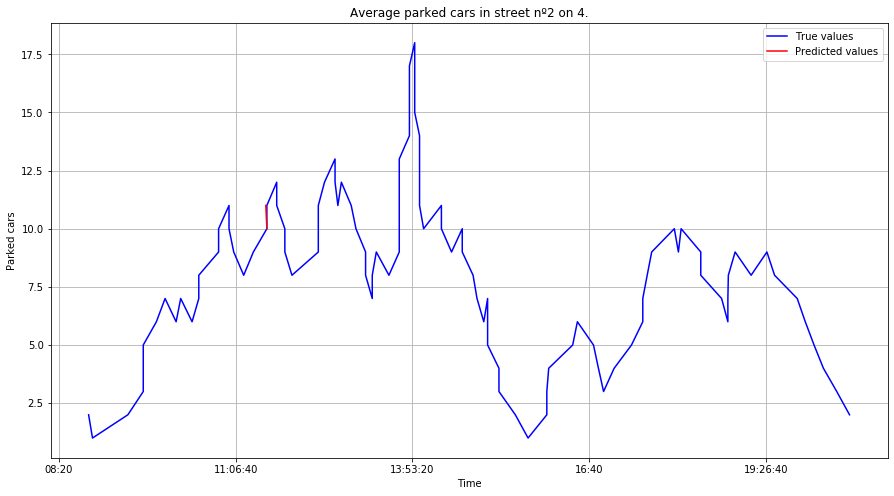

In [83]:
start_time = true_data['tiempo'].iloc[start_index]
finish_time = true_data['tiempo'].iloc[finish_index]
predictions_needed = int((finish_time - start_time) / (period * 60))
if period <= 0:
    predictions_needed = 1

print(finish_time)
plot_true_data = true_data.copy()

weekday = plot_true_data['dia de semana'][0]

def denormalize_time_to_date(time):
    return pd.Timestamp(time, unit='s').time()


#print(start_index, finish_index)

plot_true_data['tiempo'] = plot_true_data['tiempo'].apply(normalize_time)

def init_test(data, data_columns=['tiempo','ocupacion','operacion']):
    global train_size, features
    #print(data)
    street = data['id_cuadra'].iloc[0]
    weekday = data['dia de semana'].iloc[0]
    season = data['estacion'].iloc[0]
    d = data[data_columns]
    weather = data.iloc[-1][['FeelsLikeC', 'precipMM', 'windspeedKmph']]
    street = np.array(street).reshape(1,1)
    weekday = np.array(street).reshape(1,1)
    season = np.array(season).reshape(1,1)
    d = np.array(d).reshape(1,train_size,features)
    weather = np.array(weather).reshape(1,3)
    return street, weekday, season, d, weather

def prepare_test_data(data, predicted_data, predicted_time, predicted_operation=None, data_columns=['tiempo','ocupacion','operacion']):
    #last = data[0]
    if 'operacion' in data_columns:
         
        #out = np.concatenate([data[0], np.array([predicted_time, predicted_data, predicted_operation]).reshape(1,features)])
        out = np.concatenate([data[0], np.array([predicted_data, predicted_operation]).reshape(1,features)])
        out = out[1:out.shape[0]].reshape(1, train_size, features)
        #last[-1]
        #print('TODO')
    else:
        #print(data[0])
        #print(np.array([predicted_time,predicted_data]))
        
        #print(np.concatenate([data[0], np.array([predicted_time,predicted_data]).reshape(1,features)]))
        
        out = np.concatenate([data[0], np.array([predicted_time,predicted_data]).reshape(1,features)])
        out = out[1:out.shape[0]].reshape(1, train_size, features)
        #print(out)
        #print(out.shape[1])
    return out
    
def get_predicted_operation(data, predicted_data):
    #print(clean_predictions(denormalize_ocupation(data[0][-1][1])), clean_predictions(denormalize_ocupation(predicted_data)))
    
    predicted_operation = 1
    print(predicted_data)
    if clean_predictions(denormalize_ocupation(data[0][-1][0])) == clean_predictions(denormalize_ocupation(predicted_data)):
        predicted_operation = 0
    elif clean_predictions(denormalize_ocupation(data[0][-1][0])) > clean_predictions(denormalize_ocupation(predicted_data)):
        predicted_operation = -1
    return predicted_operation

#print(plot_true_data)

test_street, test_weekday, test_season, test_data, test_weather = init_test(plot_true_data[start_index-train_size+1:start_index+1], data_columns=data_columns)

plot_predicted_data = pd.DataFrame(columns=data_columns)

last_data_time = plot_true_data.iloc[start_index].tiempo#test_data[0][test_data.shape[1]-1][0]

#print(test_data[0])

plot_predicted_data = plot_predicted_data.append({'ocupacion':test_data[0][test_data.shape[1]-1][0], 'tiempo':last_data_time}, ignore_index=True)
#plot_predicted_data = plot_predicted_data.append({'ocupacion':denormalize_ocupation(test_data[0][test_data.shape[1]-1][1]), 'tiempo':last_data_time}, ignore_index=True)

#print(last_data_time)


t_test_street = tf.convert_to_tensor(test_street, np.float64)
t_test_weekday = tf.convert_to_tensor(test_weekday, np.float64)
t_test_season = tf.convert_to_tensor(test_season, np.float64)
t_test_weather = tf.convert_to_tensor(test_weather, np.float64)

#print(to_seconds(denormalize_time(last_data_time)))
for i in range(predictions_needed):
    print('Iteration: {} of {}'.format(i, (predictions_needed)))
          
    #print(test_data)
    

    t_test_data = tf.convert_to_tensor(test_data, np.float64)
    
    pred_value = model.predict([t_test_street, t_test_weekday, t_test_season, t_test_data, t_test_weather])[1][0][0]
    pred_time = last_data_time + normalize_time(period * 60)
    pred_operation = get_predicted_operation(test_data, pred_value)
    
    #if i == 1 or i == 2 or i == 3:
    #    print(pred_value)
    if 'operacion' in data_columns:
        plot_predicted_data = plot_predicted_data.append({'ocupacion': pred_value, 'tiempo': pred_time, 'operacion': pred_operation}, ignore_index=True)
        test_data = prepare_test_data(test_data, predicted_data=pred_value, predicted_time=pred_time, predicted_operation=pred_operation, data_columns=data_columns)

    else:
        plot_predicted_data = plot_predicted_data.append({'ocupacion': pred_value, 'tiempo': pred_time}, ignore_index=True)
        test_data = prepare_test_data(test_data, predicted_data=pred_value, predicted_time=pred_time, data_columns=data_columns)

    last_data_time = pred_time


plot_true_data['tiempo'] = plot_true_data['tiempo'].apply(denormalize_time)
plot_true_data['ocupacion'] = plot_true_data['ocupacion'].apply(denormalize_ocupation)
plot_predicted_data['tiempo'] = plot_predicted_data['tiempo'].apply(denormalize_time)
plot_predicted_data['ocupacion'] = plot_predicted_data['ocupacion'].apply(denormalize_ocupation)
plot_predicted_data['ocupacion'] = plot_predicted_data['ocupacion'].apply(clean_predictions)


#Set the label titles
plt.xlabel('Time')
plt.ylabel('Parked cars')
plt.title('Average parked cars in street nº{} on {}.'.format(test_street[0][0], weekday))

#Set the plot data for each graph (ax1,ax2,ax3)
plt.plot(plot_true_data['tiempo'], plot_true_data['ocupacion'], c='b')
plt.plot(plot_predicted_data['tiempo'], plot_predicted_data['ocupacion'], c='r')

#clear_output()

print('TODO: falta actualizar el clima por cada prediccion realizada')

plt.rcParams['figure.figsize'] = (15,8)
plt.grid()
plt.legend(['True values','Predicted values'])
#plt.xticks(normalized_data['fecha_hora'], time)
plt.show()

In [84]:
plot_predicted_data[0:100]

,ocupacion,operacion,tiempo
0,10,NaN,11:36:11
1,11,1.0,11:35:11


In [57]:
'''i = 2

a = np.array(t_train_weekday[i])
a = np.reshape(a, (1,1))

b = np.array(t_train_street[i])
b = np.reshape(b, (1,1))

c = np.array(t_train_season[i])
c = np.reshape(c, (1,1))
#c = np.array(train_time[0][0])
#c = np.reshape(c, (1,1))

d = np.array(t_train_data[i])
d = np.reshape(d, (1,train_size,features))
d = tf.convert_to_tensor(d, np.float64)

not_normalized_data = []

for i in range(train_size):
    not_normalized_data.append(float(d[0][i][0]) * max_ocup)
    
    
print('Weekday: ', a[0])
print('Street:  ', b[0])
print('Season:    ', c[0])
print('Data:    ', d[0])
print('Not normalized data: ', not_normalized_data)
print('Targets: ', t_targets[i])
print('Targets: ', t_targets[i] * max_ocup)'''

"i = 2\n\na = np.array(t_train_weekday[i])\na = np.reshape(a, (1,1))\n\nb = np.array(t_train_street[i])\nb = np.reshape(b, (1,1))\n\nc = np.array(t_train_season[i])\nc = np.reshape(c, (1,1))\n#c = np.array(train_time[0][0])\n#c = np.reshape(c, (1,1))\n\nd = np.array(t_train_data[i])\nd = np.reshape(d, (1,train_size,features))\nd = tf.convert_to_tensor(d, np.float64)\n\nnot_normalized_data = []\n\nfor i in range(train_size):\n    not_normalized_data.append(float(d[0][i][0]) * max_ocup)\n    \n    \nprint('Weekday: ', a[0])\nprint('Street:  ', b[0])\nprint('Season:    ', c[0])\nprint('Data:    ', d[0])\nprint('Not normalized data: ', not_normalized_data)\nprint('Targets: ', t_targets[i])\nprint('Targets: ', t_targets[i] * max_ocup)"

In [58]:
'''print('Valor predicho: ', model.predict([a, b, c, d])[0][0])
print('Valor predicho (si normalizar es necesario): ', model.predict([a, b, c, d])[0][0] * max_ocup)

import math #funcion techo
#print('Valor predicho techo: ', math.ceil(model.predict([a, b, d])[0][0]))

print('Valor real:     ', t_targets[i] * max_ocup)'''

"print('Valor predicho: ', model.predict([a, b, c, d])[0][0])\nprint('Valor predicho (si normalizar es necesario): ', model.predict([a, b, c, d])[0][0] * max_ocup)\n\nimport math #funcion techo\n#print('Valor predicho techo: ', math.ceil(model.predict([a, b, d])[0][0]))\n\nprint('Valor real:     ', t_targets[i] * max_ocup)"

In [59]:
'''index = 1


plot_true_data = data_week[indexes[index]:indexes[index+1]].copy().reset_index(drop=True)

weekday = plot_true_data['dia de semana'][0]
def denormalize_time_to_date(time):
    return pd.Timestamp(time, unit='s').time()

quarter = int(len(plot_true_data) * 1/4)
three_quarter = int(quarter * 3)

#three_quarter_time = plot_true_data.iloc[three_quarter]['tiempo']

plot_true_data['tiempo'] = plot_true_data['tiempo'].apply(normalize_time)

def init_test(data, data_columns=['tiempo','ocupacion','operacion']):
    global train_size, features
    street = data['id_cuadra'].iloc[0]
    weekday = data['dia de semana'].iloc[0]
    season = data['estacion'].iloc[0]
    d = data[data_columns]
    street = np.array(street).reshape(1,1)
    weekday = np.array(street).reshape(1,1)
    season = np.array(season).reshape(1,1)
    d = np.array(d).reshape(1,train_size,features)
    return street, weekday, season, d

def prepare_test_data(data, predicted_data, predicted_time, data_columns=['tiempo','ocupacion','operacion']):
    last = data[0]
    if 'operacion' in data_columns:
        last[-1]
        print('TODO')
    else:
        #print(data[0])
        #print(np.array([predicted_time,predicted_data]))
        
        #print(np.concatenate([data[0], np.array([predicted_time,predicted_data]).reshape(1,features)]))
        
        out = np.concatenate([data[0], np.array([predicted_time,predicted_data]).reshape(1,features)])
        out = out[1:out.shape[0]].reshape(1, train_size, features)
        #print(out)
        #print(out.shape[1])
    return out
    
#print(plot_true_data)

test_street, test_weekday, test_season, test_data = init_test(plot_true_data[-train_size-1-quarter:-1-quarter], data_columns=data_columns)

plot_predicted_data = pd.DataFrame(columns=data_columns)

last_data_time = test_data[0][test_data.shape[1]-1][0]

plot_predicted_data = plot_predicted_data.append({'ocupacion':test_data[0][test_data.shape[1]-1][1], 'tiempo':last_data_time}, ignore_index=True)
#plot_predicted_data = plot_predicted_data.append({'ocupacion':denormalize_ocupation(test_data[0][test_data.shape[1]-1][1]), 'tiempo':last_data_time}, ignore_index=True)

print(test_data)

for i in range(len(plot_true_data)-quarter):
    print('Iteration: {} of {}'.format(i, len(plot_true_data)-quarter-1))

    pred_value = model.predict([test_street, test_weekday, test_season, test_data])[0][0]
    pred_time = last_data_time + normalize_time(period * 60)
    
    #if i == 1 or i == 2 or i == 3:
    #    print(pred_value)
    
    plot_predicted_data = plot_predicted_data.append({'ocupacion': pred_value, 'tiempo': pred_time}, ignore_index=True)
    last_data_time = pred_time
    test_data = prepare_test_data(test_data, predicted_data=pred_value, predicted_time=pred_time, data_columns=data_columns)


plot_true_data['tiempo'] = plot_true_data['tiempo'].apply(denormalize_time)
plot_true_data['ocupacion'] = plot_true_data['ocupacion'].apply(denormalize_ocupation)
plot_predicted_data['tiempo'] = plot_predicted_data['tiempo'].apply(denormalize_time)
plot_predicted_data['ocupacion'] = plot_predicted_data['ocupacion'].apply(denormalize_ocupation)
plot_predicted_data['ocupacion'] = plot_predicted_data['ocupacion'].apply(clean_predictions)


#Set the label titles
plt.xlabel('Time')
plt.ylabel('Parked cars')
plt.title('Average parked cars in street nº{} on {}.'.format(test_street[0][0], weekday))

#Set the plot data for each graph (ax1,ax2,ax3)
plt.plot(plot_true_data['tiempo'], plot_true_data['ocupacion'], c='b')
plt.plot(plot_predicted_data['tiempo'], plot_predicted_data['ocupacion'], c='r')

clear_output()

plt.rcParams['figure.figsize'] = (15,8)
plt.grid()
plt.legend(['True values','Predicted values'])
#plt.xticks(normalized_data['fecha_hora'], time)
plt.show()'''

"index = 1\n\n\nplot_true_data = data_week[indexes[index]:indexes[index+1]].copy().reset_index(drop=True)\n\nweekday = plot_true_data['dia de semana'][0]\ndef denormalize_time_to_date(time):\n    return pd.Timestamp(time, unit='s').time()\n\nquarter = int(len(plot_true_data) * 1/4)\nthree_quarter = int(quarter * 3)\n\n#three_quarter_time = plot_true_data.iloc[three_quarter]['tiempo']\n\nplot_true_data['tiempo'] = plot_true_data['tiempo'].apply(normalize_time)\n\ndef init_test(data, data_columns=['tiempo','ocupacion','operacion']):\n    global train_size, features\n    street = data['id_cuadra'].iloc[0]\n    weekday = data['dia de semana'].iloc[0]\n    season = data['estacion'].iloc[0]\n    d = data[data_columns]\n    street = np.array(street).reshape(1,1)\n    weekday = np.array(street).reshape(1,1)\n    season = np.array(season).reshape(1,1)\n    d = np.array(d).reshape(1,train_size,features)\n    return street, weekday, season, d\n\ndef prepare_test_data(data, predicted_data, predict

# Otra red, utilizando lo valores de tiempo originales del dataset. Se buscara predecir el tiempo y la capacidad en ese momento.

In [211]:
#Para la calle
input_street = Input(shape=(1), name='input_street')
#emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=32)(input_street)
emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=64)(input_street)
flat_street = Flatten()(input_street)
#d_street = Dense(16, activation='relu')(flat_street)

#Para el dia de la semana
input_weekday = Input(shape=(1), name='input_weekday')
#emb_weekday = Embedding(input_length=1, input_dim=7, output_dim=16)(input_weekday)
emb_weekday = Embedding(input_length=1, input_dim=6, output_dim=16)(input_weekday)
flat_weekday = Flatten()(emb_weekday)
#d_weekday = Dense(8, activation='relu')(flat_weekday)

#Para el tiempo y la ocupacion y la operacion o los valores que tenga la data a procesar
input_data = Input(shape=(train_size, features), name='input_data')
#lstm = LSTM(16, return_sequences=False, recurrent_dropout=0.25)(input_data)
#lstm_layer = LSTM(8, return_sequences=True, recurrent_dropout=0.25)(input_data)
lstm_1 = LSTM(32, return_sequences=False, recurrent_dropout=0.25)(input_data)
lstm_2 = LSTM(32, return_sequences=False, recurrent_dropout=0.25)(lstm_1)
lstm_3 = LSTM(32, return_sequences=False, recurrent_dropout=0.25)(lstm_2)
lstm_4 = LSTM(32, return_sequences=False, recurrent_dropout=0.25)(lstm_3)
lstm = LSTM(32, return_sequences=False, recurrent_dropout=0.25)(lstm_4)

#Para la estacion del año
input_season = Input(shape=(1), name='input_season')
emb_season = Embedding(input_length=1, input_dim=4, output_dim=8)(input_season)
flat_season = Flatten()(emb_season)
#d_season = Dense(8, activation='relu')(flat_season)

#Para el clima
input_weather = Input(shape=(3), name='input_weather')

#Para el tiempo a predecir 
#No agrega valor, hace mas chota a la red. En vez de esto voy a arreglar el tiempo en los datos
#y hacer que sea cada cierta cantidad de minutos siempre.
#input_time = Input(shape=(1), name='input_time')

concat = Concatenate(axis=-1)
input_merge = concat([flat_weekday, flat_street])
input_merge = concat([input_merge, lstm])
input_merge = concat([input_merge, flat_season])
input_merge = concat([input_merge, input_weather])
#input_merge = concat([input_merge, input_time])

d = Dense(128, activation='relu')(input_merge)
d = Dropout(0.25)(d)
#d = Dense(64, activation='relu')(d)
#d = Dropout(0.5)(d)
#d = Dense(64, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
#d = Dense(128, activation='relu')(d)
d = Dense(128, activation='relu')(d)
d = Dropout(0.5)(d)
#d = Dense(32, activation='relu')(d)
#d = Dropout(0.25)(d)
time = Dense(1, activation='linear', name='out_time')(d)
ocupation = Dense(1, activation='linear', name='out_ocup')(d)

model = Model(inputs=[input_weekday, input_street, input_season, input_data, input_weather], outputs=[time, ocupation])
model.summary()
model.compile(loss='MSE', optimizer='adam', metrics=['MAE'])

ValueError: Input 0 of layer lstm_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 32]

In [212]:
#h = model.fit([s_train_weekday, s_train_street, s_train_data], s_targets, epochs=5, batch_size=64, validation_split=0.1)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00000001)

#h = model.fit([t_train_weekday, t_train_street, t_train_data], t_targets, epochs=20, batch_size=32, validation_split=0.2, callbacks=[red_lr])
#h = model.fit([t_train_weekday, t_train_street, t_train_season, t_train_data], den_targets, epochs=20, batch_size=512, validation_split=0.2, callbacks=[red_lr])
h = model.fit([t_train_weekday, t_train_street, t_train_season, t_train_data, t_train_weather], [t_dif_time_targets, t_targets], epochs=10, batch_size=64, validation_split=0.1, callbacks=[red_lr])

Train on 139608 samples, validate on 15513 samples
Epoch 1/10
139608/139608 [==============================] - 13s 93us/sample - loss: 984644.6344 - out_time_loss: 984719.2500 - out_ocup_loss: 0.0094 - out_time_MAE: 424.1365 - out_ocup_MAE: 0.0696 - val_loss: 860704.8371 - val_out_time_loss: 859329.8125 - val_out_ocup_loss: 0.0167 - val_out_time_MAE: 429.0495 - val_out_ocup_MAE: 0.1062
Epoch 2/10
139608/139608 [==============================] - 13s 91us/sample - loss: 982880.5698 - out_time_loss: 982673.0000 - out_ocup_loss: 0.0107 - out_time_MAE: 424.5411 - out_ocup_MAE: 0.0723 - val_loss: 858582.0278 - val_out_time_loss: 857186.6250 - val_out_ocup_loss: 0.0115 - val_out_time_MAE: 425.4536 - val_out_ocup_MAE: 0.0606
Epoch 3/10
139608/139608 [==============================] - 13s 96us/sample - loss: 984589.5452 - out_time_loss: 984390.3750 - out_ocup_loss: 0.0097 - out_time_MAE: 424.9858 - out_ocup_MAE: 0.0705 - val_loss: 858786.7489 - val_out_time_loss: 857368.8125 - val_out_ocup_loss

In [213]:
t_train_data[0]

<tf.Tensor: id=831223, shape=(10, 2), dtype=float64, numpy=
array([[ 0.21568627,  1.        ],
       [ 0.19607843, -1.        ],
       [ 0.21568627,  1.        ],
       [ 0.19607843, -1.        ],
       [ 0.15686275, -1.        ],
       [ 0.07843137, -1.        ],
       [ 0.11764706,  1.        ],
       [ 0.15686275,  1.        ],
       [ 0.11764706, -1.        ],
       [ 0.15686275,  1.        ]])>

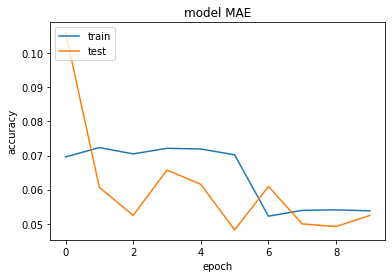

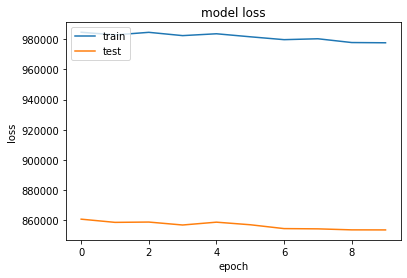

In [214]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['out_ocup_MAE'])
plt.plot(h.history['val_out_ocup_MAE'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [215]:
pd.DataFrame(h.history['out_ocup_loss']).apply(denormalize_ocupation)

,0
0,0.478354
1,0.545873
2,0.494859
3,0.538331
4,0.559255
5,0.517690
6,0.245805
7,0.265050
8,0.265545
9,0.262503


In [216]:
'''for t in (h.history['out_time_loss']):
    print(to_seconds(denormalize_time(t)))'''

"for t in (h.history['out_time_loss']):\n    print(to_seconds(denormalize_time(t)))"

In [235]:
index = 0

true_data = data_week[indexes[index]:indexes[index+1]].copy().reset_index(drop=True)
true_data['tiempo'].apply(normalize_time).apply(denormalize_time).drop_duplicates()

0     17:15:31
1     17:20:25
2     17:34:54
3     17:40:09
4     17:45:05
5     17:54:43
6     18:00:29
8     18:04:18
10    18:10:27
11    18:12:52
12    18:25:02
15    18:30:11
16    18:34:45
17    18:50:36
20    18:52:10
21    19:00:25
22    19:04:46
23    19:15:11
24    19:22:02
25    19:30:28
27    19:31:03
28    19:40:08
29    19:42:29
30    20:00:29
31    20:13:23
32    20:48:47
Name: tiempo, dtype: object

In [241]:
start_index = 28
finish_index = 32

548.6792
514.91724
527.9705
516.73694
509.99008
507.61035
505.3484
503.5716
TODO: falta actualizar el clima por cada prediccion realizada
TODO: podria ser que tenga que predecir en cuantos minutos va a ser la proxima accion


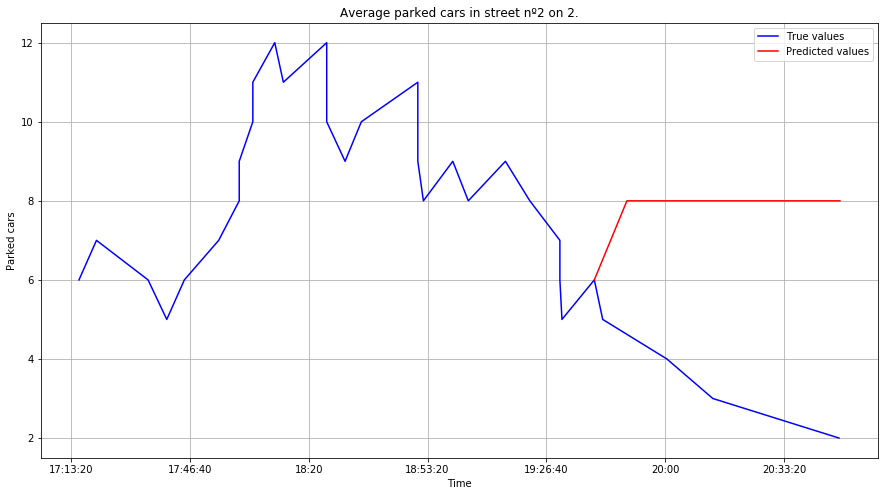

In [242]:
start_time = true_data['tiempo'].iloc[start_index]
finish_time = true_data['tiempo'].iloc[finish_index]
predictions_needed = int((finish_time - start_time))

plot_true_data = true_data.copy()

weekday = plot_true_data['dia de semana'][0]

def denormalize_time_to_date(time):
    return pd.Timestamp(time, unit='s').time()


#print(start_index, finish_index)

plot_true_data['tiempo'] = plot_true_data['tiempo'].apply(normalize_time)

def init_test(data, data_columns=['tiempo','ocupacion','operacion']):
    global train_size, features
    #print(data)
    street = data['id_cuadra'].iloc[0]
    weekday = data['dia de semana'].iloc[0]
    season = data['estacion'].iloc[0]
    d = data[data_columns]
    weather = data.iloc[-1][['FeelsLikeC', 'precipMM', 'windspeedKmph']]
    street = np.array(street).reshape(1,1)
    weekday = np.array(street).reshape(1,1)
    season = np.array(season).reshape(1,1)
    d = np.array(d).reshape(1,train_size,features)
    weather = np.array(weather).reshape(1,3)
    return street, weekday, season, d, weather

def prepare_test_data(data, predicted_data, predicted_time, predicted_operation=None, data_columns=['tiempo','ocupacion','operacion']):
    #last = data[0]
    if 'operacion' in data_columns:

        #out = np.concatenate([data[0], np.array([predicted_time, predicted_data, predicted_operation]).reshape(1,features)])
        out = np.concatenate([data[0], np.array([predicted_data, predicted_operation]).reshape(1,features)])
        out = out[1:out.shape[0]].reshape(1, train_size, features)
        #last[-1]
        #print('TODO')
    else:
        #print(data[0])
        #print(np.array([predicted_time,predicted_data]))
        
        #print(np.concatenate([data[0], np.array([predicted_time,predicted_data]).reshape(1,features)]))
        out = np.concatenate([data[0], np.array([predicted_time,predicted_data]).reshape(1,features)])
        out = out[1:out.shape[0]].reshape(1, train_size, features)
        #print(out)
        #print(out.shape[1])
    return out
    
def get_predicted_operation(data, predicted_data):
    #print(clean_predictions(denormalize_ocupation(data[0][-1][1])), clean_predictions(denormalize_ocupation(predicted_data)))
    
    predicted_operation = 1
    if clean_predictions(denormalize_ocupation(data[0][-1][0])) == clean_predictions(denormalize_ocupation(predicted_data)):
        predicted_operation = 0
    elif clean_predictions(denormalize_ocupation(data[0][-1][0])) > clean_predictions(denormalize_ocupation(predicted_data)):
        predicted_operation = -1
    return predicted_operation

#print(plot_true_data)

test_street, test_weekday, test_season, test_data, test_weather = init_test(plot_true_data[start_index-train_size+1:start_index+1], data_columns=data_columns)

plot_predicted_data = pd.DataFrame(columns=data_columns)

last_data_time = plot_true_data.iloc[start_index].tiempo#test_data[0][test_data.shape[1]-1][0]

#print(test_data[0])

plot_predicted_data = plot_predicted_data.append({'ocupacion':test_data[0][test_data.shape[1]-1][0], 'tiempo':last_data_time}, ignore_index=True)
#plot_predicted_data = plot_predicted_data.append({'ocupacion':denormalize_ocupation(test_data[0][test_data.shape[1]-1][1]), 'tiempo':last_data_time}, ignore_index=True)

#print(last_data_time)


t_test_street = tf.convert_to_tensor(test_street, np.float64)
t_test_weekday = tf.convert_to_tensor(test_weekday, np.float64)
t_test_season = tf.convert_to_tensor(test_season, np.float64)
t_test_weather = tf.convert_to_tensor(test_weather, np.float64)

#print((denormalize_time(last_data_time)))


while ( predictions_needed > 0 ):

    t_test_data = tf.convert_to_tensor(test_data, np.float64)


    pred_time, pred_value = model.predict([t_test_street, t_test_weekday, t_test_season, t_test_data, t_test_weather])
    pred_value = pred_value[0][0]
    pred_time = pred_time[0][0]
    
    print(pred_time)
    
    pred_time = last_data_time + normalize_time(pred_time)
    pred_operation = get_predicted_operation(test_data, pred_value)
    
    
    if 'operacion' in data_columns:
        plot_predicted_data = plot_predicted_data.append({'ocupacion': pred_value, 'tiempo': pred_time, 'operacion': pred_operation}, ignore_index=True)
        test_data = prepare_test_data(test_data, predicted_data=pred_value, predicted_time=pred_time, predicted_operation=pred_operation, data_columns=data_columns)
    
    else:
        plot_predicted_data = plot_predicted_data.append({'ocupacion': pred_value, 'tiempo': pred_time}, ignore_index=True)
        test_data = prepare_test_data(test_data, predicted_data=pred_value, predicted_time=pred_time, data_columns=data_columns)

    last_data_time = pred_time
    
    predictions_needed = finish_time - to_seconds(denormalize_time(pred_time))


plot_true_data['tiempo'] = plot_true_data['tiempo'].apply(denormalize_time)
plot_true_data['ocupacion'] = plot_true_data['ocupacion'].apply(denormalize_ocupation)
plot_predicted_data['tiempo'] = plot_predicted_data['tiempo'].apply(denormalize_time)
plot_predicted_data['ocupacion'] = plot_predicted_data['ocupacion'].apply(denormalize_ocupation)
plot_predicted_data['ocupacion'] = plot_predicted_data['ocupacion'].apply(clean_predictions)


#Set the label titles
plt.xlabel('Time')
plt.ylabel('Parked cars')
plt.title('Average parked cars in street nº{} on {}.'.format(test_street[0][0], weekday))

#Set the plot data for each graph (ax1,ax2,ax3)
plt.plot(plot_true_data['tiempo'], plot_true_data['ocupacion'], c='b')
plt.plot(plot_predicted_data['tiempo'], plot_predicted_data['ocupacion'], c='r')

#clear_output()

print('TODO: falta actualizar el clima por cada prediccion realizada')
print('TODO: podria ser que tenga que predecir en cuantos minutos va a ser la proxima accion')
plt.rcParams['figure.figsize'] = (15,8)
plt.grid()
plt.legend(['True values','Predicted values'])
#plt.xticks(normalized_data['fecha_hora'], time)
plt.show()

In [243]:
plot_predicted_data[0:100]

,ocupacion,operacion,tiempo
0,6,NaN,19:40:08
1,8,1.0,19:49:16.679199
2,8,0.0,19:57:51.596435
3,8,0.0,20:06:39.566955
4,8,0.0,20:15:16.303894
5,8,0.0,20:23:46.293975
6,8,0.0,20:32:13.904327
7,8,0.0,20:40:39.252716
8,8,0.0,20:49:02.824310


In [221]:
i = 2

a = np.array(t_train_weekday[i])
a = np.reshape(a, (1,1))

b = np.array(t_train_street[i])
b = np.reshape(b, (1,1))

c = np.array(t_train_season[i])
c = np.reshape(c, (1,1))
#c = np.array(train_time[0][0])
#c = np.reshape(c, (1,1))

d = np.array(t_train_data[i])
d = np.reshape(d, (1,train_size,features))
d = tf.convert_to_tensor(d, np.float64)

e = np.array(t_train_weather[i])
e = np.reshape(e, (1, 3))
e = tf.convert_to_tensor(e, np.float64)

not_normalized_data = []

for j in range(train_size):
    not_normalized_data.append(float(d[0][j][0]) * max_ocup)
    
    
print('Weekday: ', a[0])
print('Street:  ', b[0])
print('Season:    ', c[0])
print('Data:    ', d[0])
print('Not normalized data: ', not_normalized_data)
print('Weather:    ', e[0])
print('Targets: ', t_targets[i])
print('Targets: ', denormalize_ocupation(t_targets[i]))
print('Time targets: ', t_dif_time_targets[i])

Weekday:  [2.]
Street:   [66.]
Season:     [0.]
Data:     tf.Tensor(
[[ 0.03921569  1.        ]
 [ 0.05882353  1.        ]
 [ 0.03921569 -1.        ]
 [ 0.05882353  1.        ]
 [ 0.03921569 -1.        ]
 [ 0.01960784 -1.        ]
 [ 0.03921569  1.        ]
 [ 0.01960784 -1.        ]
 [ 0.03921569  1.        ]
 [ 0.01960784 -1.        ]], shape=(10, 2), dtype=float64)
Not normalized data:  [2.0, 3.0000000000000004, 2.0, 3.0000000000000004, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0]
Weather:     tf.Tensor([0.46808511 0.         0.46341463], shape=(3,), dtype=float64)
Targets:  tf.Tensor(0.0392156862745098, shape=(), dtype=float64)
Targets:  tf.Tensor(2.0, shape=(), dtype=float64)
Time targets:  tf.Tensor(348.0, shape=(), dtype=float64)


In [222]:
print('Valor predicho: ', model.predict([a, b, c, d, e]))
print('Ocup predicho (si normalizar es necesario): ', model.predict([a, b, c, d, e])[1][0] * max_ocup)
print('Tiempo predicho (si normalizar es necesario): ', (model.predict([a, b, c, d, e])[0][0][0]))

import math #funcion techo
#print('Valor predicho techo: ', math.ceil(model.predict([a, b, d])[0][0]))

print('Ocup real:     ', t_targets[i] * max_ocup)
print('Tiempo real:     ', (np.array(t_dif_time_targets[i])))

Valor predicho:  [array([[1681.4385]], dtype=float32), array([[0.01569016]], dtype=float32)]
Ocup predicho (si normalizar es necesario):  [0.8001983]
Tiempo predicho (si normalizar es necesario):  1681.4385
Ocup real:      tf.Tensor(2.0, shape=(), dtype=float64)
Tiempo real:      348.0


### Para el siguiente valor (y simular calcular valores seguidos)

### En este intento voy a utilizar como dato de tiempo el dia con num y la hora

### Otra red!

### Ideas de redes:
### Cosas que deberian ir si o si de entrada: Dia de la semana, mes (cuando tenga mas datos), tiempo
### Utilizar los valores de Entrada/Salida y que prediga capacidad 
### Utilizar valores de capacidad y que prediga capacidad